# Experiment Implementation
Authors: Tanis Hadwin, Jacob Clostio, Tyler Koon, and Chris Vazquez

To consider how the KMeans++ and Hartigan Wong KMeans algorithms compare with traditional KMeans, we devised a simple experiment that compares the mean F1 Score across a range of different testing conditions. For more detail on the experimental design and underlying research questions, please see the accompanying project report.

In [1]:
# Import our algorithm and utility implementations
from algorithms.initialization.HartWongKMeans import HartWongKMeans
from algorithms.initialization.KMeansPlusPlus import KMeansPlusPlus
from utilities.Preprocessor import Preprocessor
from utilities.Utilities import Utilities
from algorithms.KMeans import KMeans

# Import third party tools for working with the data
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

To facilitate data wrangling, we created a simple `Preprocessor` class that exposes a number of data wrangling operations. This includes loading in data from CSV files, dropping attributes and rows/missing data, and normalizing the data. These methods are used here to load in out Breast Cancer dataset and prepare it for analyses. The first thing we did was load in the dataset, assigning attribute names and applying some simple Pandas converters to standardize the response values. After loading this data, we then removed the 'patient_id' identifier attribute which contributes no valuable information to the relationship between predictors and the response. Additionally, decided to drop all samples that were missing attribute data--a decision that was largely motivated by the proportionately small number of samples that were missing data (16 out of 699, or less than 2% of the total samples), which we believed this would have little no impact on our underlying analyses. Finally, we applied standard normalization to these data in preparation for dimensionality reduction using Principal Component Analysis (PCA).

In [2]:
### Load and Preprocess Data ###

pp = Preprocessor()

column_names = ["patient_id", "clump_thickness", "size_uniformity", "shape_uniformity", "marginal_adhesion", "epithelial_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitosis", "class"]

# Load the data
pp.load_data("./data/breast-cancer-wisconsin.data", column_names = column_names, response_name = "class", na_values = ["?"], converters = {"class": lambda value: 0 if int(value) == 2 else 1})

# Remove the patient_id column which contribute no valuable information
pp.drop_columns("patient_id")

# Remove any rows with missing samples
pp.drop_na()

# Standard normalize the data
pp.normalize()

With the data processed, we then performed dimensionality reduction using PCA. The main motivation behind this decision was to reduce the complexity of our data, making results more digestible and easier to visualize. That said, this is a potential limitation of our study as it harms interpretability of results and introduces uncertainty in the applicability of our results to higher dimensional data. Future research might consider the behavior of the three KMeans algorithms across a range of dimensions.

In [3]:
### Reduce the Dimensionality of the Data Using PCA ###

# PCA transform the data, targeting two dimensions
pca_transformer = PCA(n_components = 2)
transformed_data = pca_transformer.fit_transform(pp.data)

Following this dimensionality reduction, we generated a set of elbow plots for each of the three KMeans implementations in question. We considered a small range of k values between 1 and 10, and found that all three models tended to produce similar inertia values for each of these values. That said, the Hartigan Wong KMeans method did deviate from the KMeans and KMeans++ methods, especially around k = 4. Although we are not sure why this deviance begins around k = 4 (perhaps this is just an artifact of the underlying data), the deviance itself is not unexpected; the Hartigan Wong method implements additional changes to the frequency with which clusters are updated, unlike the KMeans and KMeans++ methods. Nonetheless, these elbow plots show that the change in inertia begins to decrease around k = 3, suggesting that 3 clusters is most optimal for these data. Based on this insight, we have decided to consider a range of k values between 1 and 6 for our experiment. Our hope is that by exploring this range of values, we can gain insight into how each of the three methods perform in both optimal and non-optimal clustering conditions.

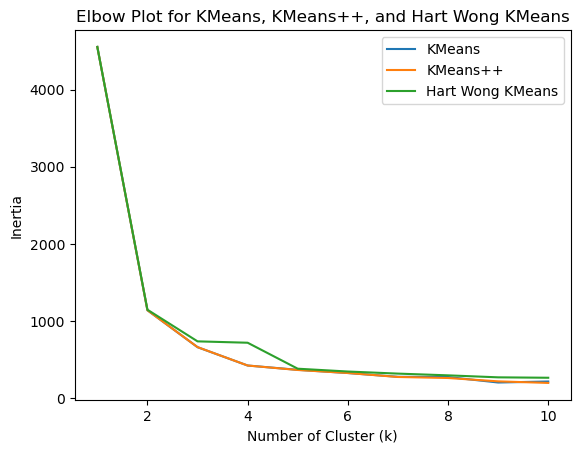

In [4]:
### Consider the 'idea' number of clusters for each method ###

# Define epsilon hyper-parameter to quantify convergence
epsilon = 0.0001

# Define range of k values to consider
k_range = range(1, 11)

# Dictionary to store inertia values
model_inertia = {"kmeans": [], "kmeanspp": [], "hwkmeans": []}

for k in k_range:
    # Generate models
    kmeans_transformer = KMeans(k, epsilon)
    kmeanspp_transformer = KMeans(k, epsilon, initialization_method = KMeansPlusPlus)
    hwkmeans_transformer = KMeans(k, epsilon, initialization_method = HartWongKMeans, is_batch_update = False)

    # Fit the models
    kmeans_transformer.fit(np.array(transformed_data))
    kmeanspp_transformer.fit(np.array(transformed_data))
    hwkmeans_transformer.fit(np.array(transformed_data))

    # Record the inertia values
    model_inertia["kmeans"].append(kmeans_transformer.intertia())
    model_inertia["kmeanspp"].append(kmeanspp_transformer.intertia())
    model_inertia["hwkmeans"].append(hwkmeans_transformer.intertia())

# Create an elbow plot for each method
plt.plot(k_range, model_inertia["kmeans"], label = "KMeans")
plt.plot(k_range, model_inertia["kmeanspp"], label = "KMeans++")
plt.plot(k_range, model_inertia["hwkmeans"], label = "Hart Wong KMeans")
plt.title("Elbow Plot for KMeans, KMeans++, and Hart Wong KMeans")
plt.xlabel("Number of Cluster (k)")
plt.ylabel("Inertia")
plt.legend()
plt.show()

In [168]:
### Set experiment parameters ###

# Define a range of clusters to explore (based on previous exploration of elbow plots)
num_clusters = range(1, 7)

# Define the number of time to fit the model for each value of k
num_iter = 100

# Create a dictionary to store clustering results
clustering_results = {
    "KMeans": dict.fromkeys(num_clusters, 0),
    "KMeans++": dict.fromkeys(num_clusters, 0),
    "Hart Wong KMeans": dict.fromkeys(num_clusters, 0)
}

With these initial investigations complete, we now implement our experiment. As previously suggested, this involves comparing the mean F1 scores for each method across a range of k values. We decided to use the F1 score to compare performance due to the standardized nature of the score, which offers an easily comparative scale. Additionally, using the F1 score offers a balanced overview of recall and precision of each method, serving to provide a more holistic overview of model performance.

In [169]:
### Fit the KMeans Algorithm ###

for k in num_clusters:
    for i in range(num_iter):
        # Define the transformer
        transformer = KMeans(k, epsilon)

        # Fit the data
        transformer.fit(np.array(transformed_data))

        # Compute and record the F1 score
        f1_score = Utilities.f_score(pp.response.to_numpy(), transformer.cluster_assignment)
        clustering_results["KMeans"][k] += f1_score

    # Compute the average F1 score
    clustering_results["KMeans"][k] /= num_iter

In [170]:
### Fit the KMeans++ Algorithm ###

# Create and apply KMeans++ transformer
for k in num_clusters:
    for i in range(num_iter):
        # Define the transformer
        transformer = KMeans(k, epsilon, initialization_method = KMeansPlusPlus)

        # Fit the data
        transformer.fit(np.array(transformed_data))

        # Compute and record the F1 score
        f1_score = Utilities.f_score(pp.response.to_numpy(), transformer.cluster_assignment)
        clustering_results["KMeans++"][k] += f1_score

    # Compute the average F1 score
    clustering_results["KMeans++"][k] /= num_iter

In [171]:
### Fit the HWKMeans Algorithm ###

# Create and apply Hart Wong KMeans transformer

for k in num_clusters:

    for i in range(num_iter):
        # Define the transformer
        transformer = KMeans(k, epsilon, initialization_method = HartWongKMeans, is_batch_update = False)

        # Fit the data
        transformer.fit(np.array(transformed_data))

        # Compute and record the F1 score
        f1_score = Utilities.f_score(pp.response.to_numpy(), transformer.cluster_assignment)
        clustering_results["Hart Wong KMeans"][k] += f1_score

    # Compute the average F1 score
    clustering_results["Hart Wong KMeans"][k] /= num_iter

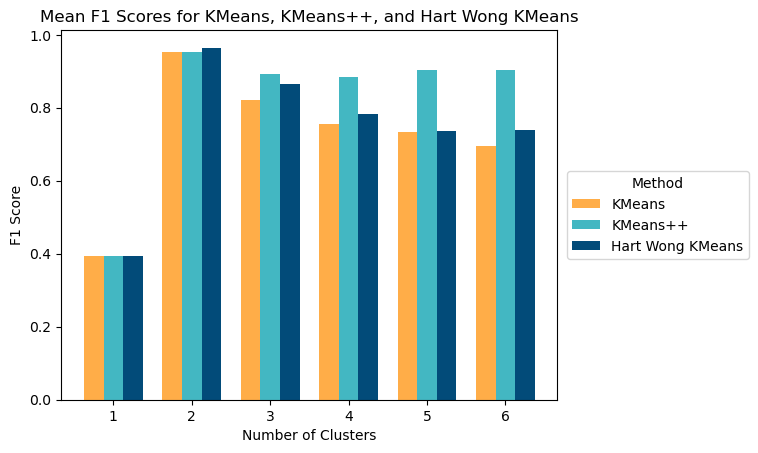

In [172]:
### Explore results ###

multiplier = 0
bar_width = 0.25

# Define colors based on methods
method_map = {
    "KMeans": "#ffad48",
    "KMeans++": "#43b7c2",
    "Hart Wong KMeans": "#024b79",
}

for method, results in clustering_results.items():
    offset = multiplier * bar_width

    # Add a bar to the plot for each method
    plt.bar(np.array(num_clusters) + offset, results.values(), width = bar_width, label = method, color = method_map[method])

    multiplier += 1

# Generate bar plot
plt.legend(title = "Method", loc = "center right", bbox_to_anchor=(1.4, 0.5))
plt.xticks(np.array(num_clusters) + bar_width, labels = num_clusters)
plt.xlabel("Number of Clusters")
plt.ylabel("F1 Score")
plt.title("Mean F1 Scores for KMeans, KMeans++, and Hart Wong KMeans")
plt.show()

Exploring the resulting performance of these methods presents some interesting behavior. Perhaps most notably, the KMeans++ method appears to be much more resistant to non-optimal values of k. This is demonstrated by a much higher mean F1 score across values of k than the competing methods. We believe this resistance to be an artifact of the more intelligent centroid initialization process in the KMeans++ algorithm, which ensures that centroids are more equitably distributed throughout the feature space. This resistance might make KMeans++ a great method to use in situations where there is little a-priori knowledge on the expected number of clusters in the data. For more optimal values of k, the Hartigan Wong method offered similar performance, slightly out-performing the traditional KMeans algorithm. That said, this performance advantage quickly decays as the number of clusters becomes less optimal, effective converging to the same performance as KMeans.

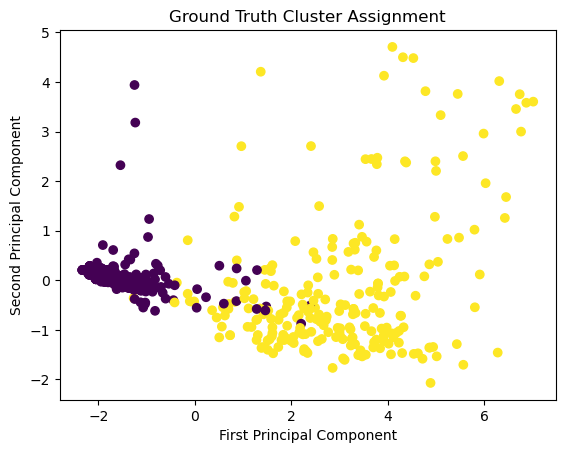

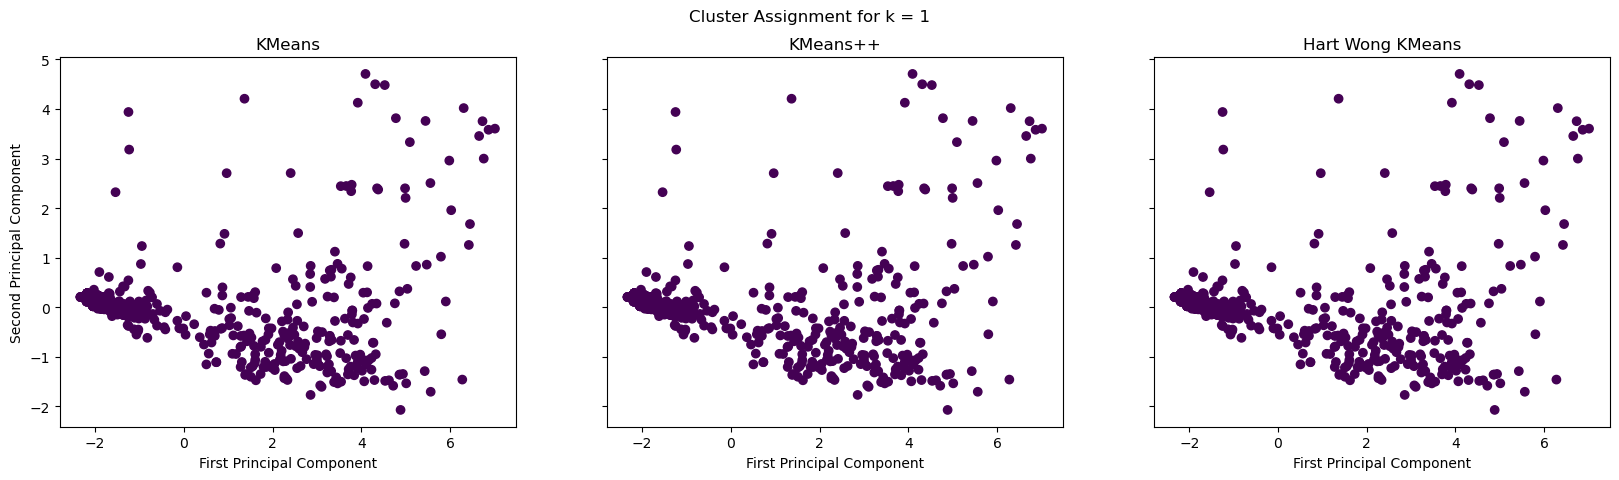

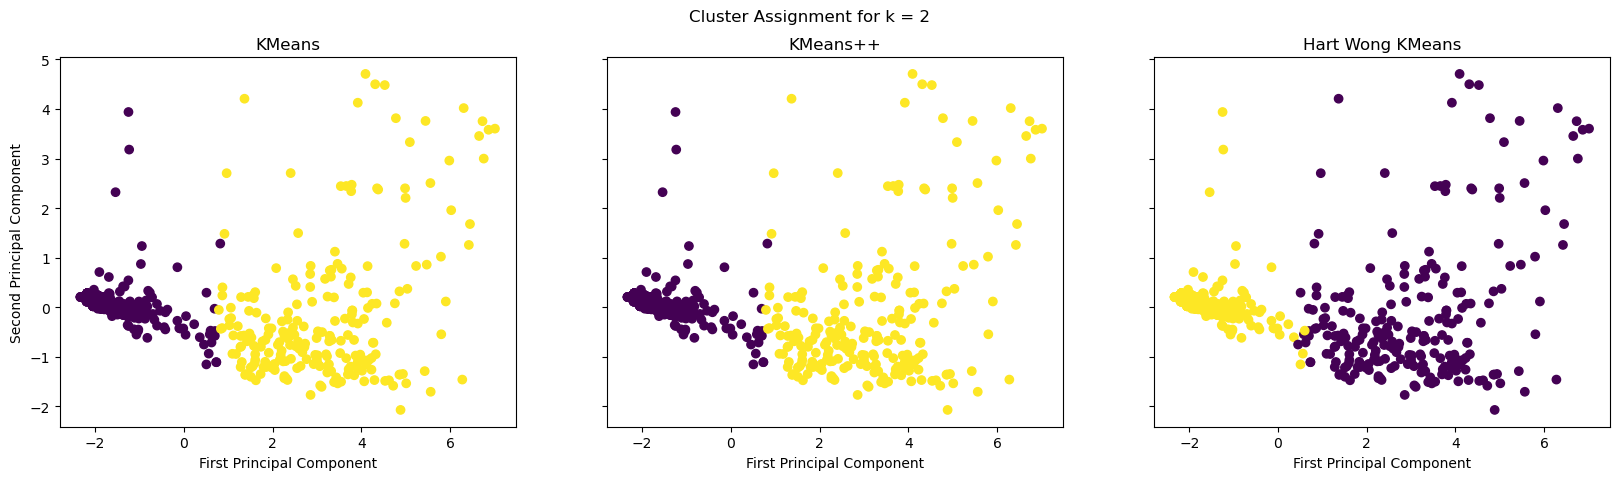

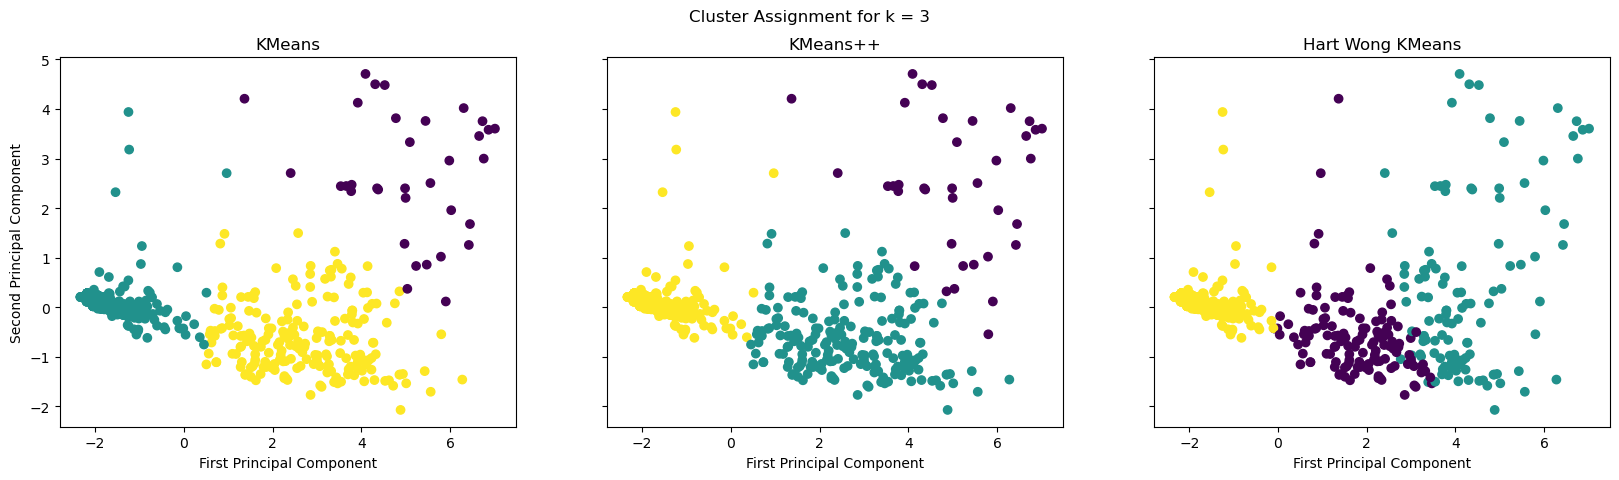

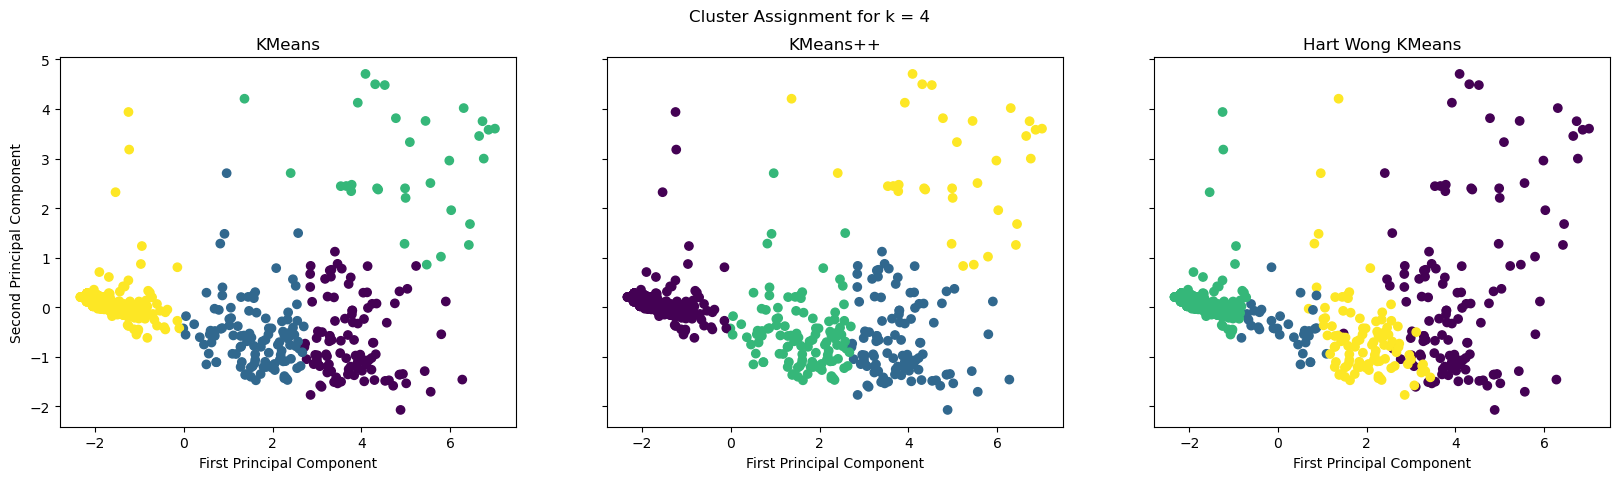

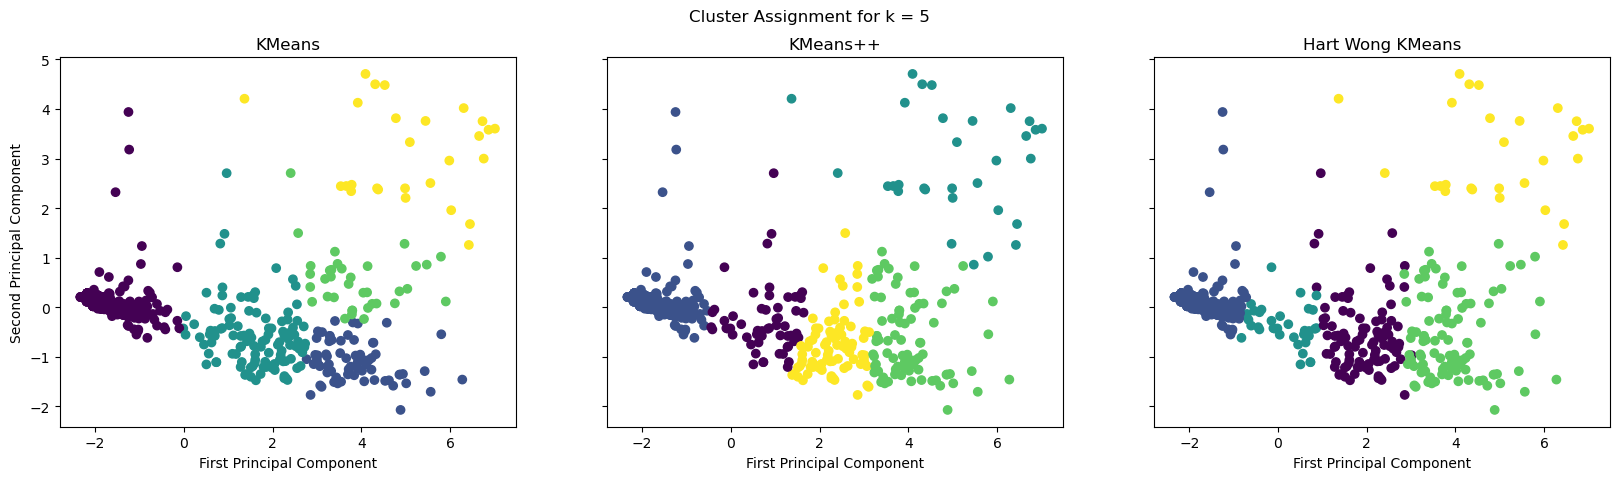

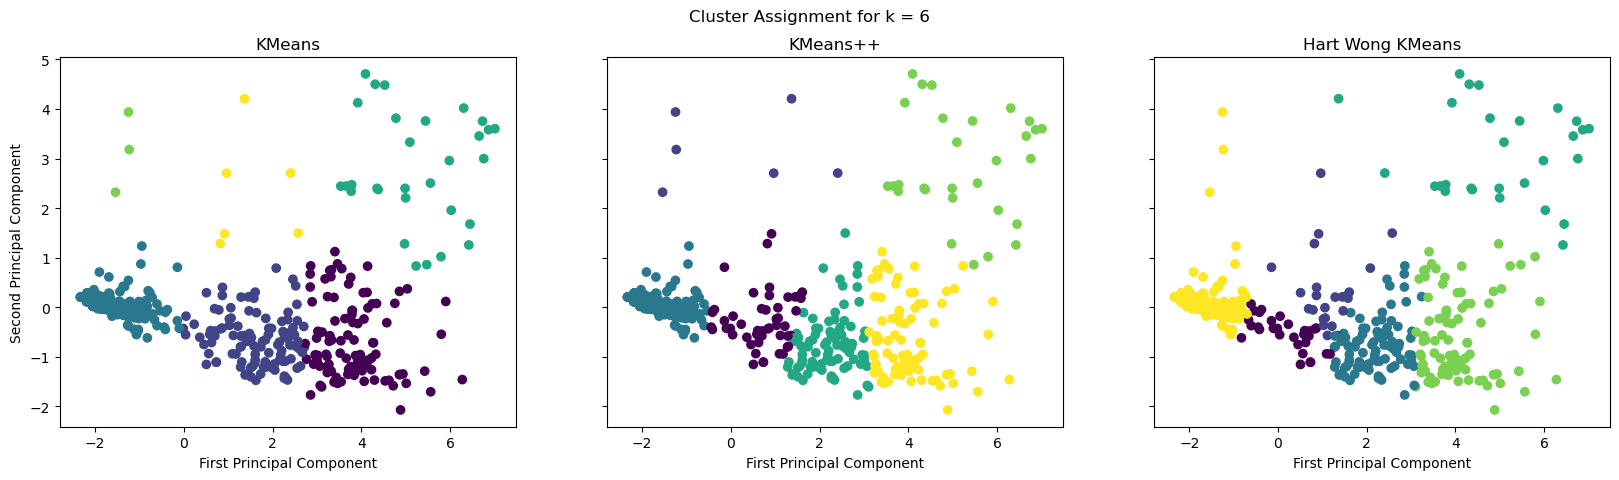

In [203]:
### Generate scatter plots for the three methods across the range of k values ###

# Generate plot of ground truth clustering

plt.scatter(transformed_data[:,0], transformed_data[:,1], c = pp.response)
plt.title("Ground Truth Cluster Assignment")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

for k in num_clusters:
    fig, axes = plt.subplots(1, 3)
    fig.set_figwidth(20)

    # Set figure title and labels
    fig.suptitle(f"Cluster Assignment for k = {k}")

    for axis in axes:
        axis.set(xlabel = "First Principal Component", ylabel = "Second Principal Component")

    # Generate and plot KMeans clustering
    kmeans_assignments = KMeans(k, epsilon).fit(np.array(transformed_data))

    axes[0].scatter(transformed_data[:,0], transformed_data[:,1], c = kmeans_assignments)
    axes[0].set_title("KMeans")
    axes[0].label_outer()

    # Generate and plot KMeans++
    kmeanspp_assignments = KMeans(k, epsilon, initialization_method = KMeansPlusPlus).fit(np.array(transformed_data))


    axes[1].scatter(transformed_data[:,0], transformed_data[:,1], c = kmeanspp_assignments)
    axes[1].set_title("KMeans++")
    axes[1].label_outer()

    # Generate and plot Hart Wong KMeans
    hwkmeans_assignments = KMeans(k, epsilon, initialization_method = HartWongKMeans, is_batch_update = False).fit(np.array(transformed_data))

    axes[2].scatter(transformed_data[:,0], transformed_data[:,1], c = hwkmeans_assignments)
    axes[2].set_title("Hart Wong KMeans")
    axes[2].label_outer()

    plt.show()

Finally, we consider differences in the clustering behavior of these three methods across the range of selected k values. For the most part, the KMeans and KMeans++ algorithms tend to produce very similar cluster assignment. Given that the underlying clustering process for these two algorithms is identical, these results were to be expected. That said, for higher values of k the KMeans++ algorithm tended  to produce slightly larger clusters, indicating that it might be better at preventing multiple centroids from converging to the same local minima. Once again, this supports our previous observations and demonstrates the resistance of KMeans++ to less-optimal clustering situations. On the other hand, the Hartigan Wong KMeans method performed similarly to KMeans++ for higher values of k, however it appeared to be much worse at dealing with differences in cluster density, especially for lower values of k. Though we are uncertain of why this behavior occurs, we believe it to be caused by the more frequent updating of centroids from this implementation, which might impact the centroid convergence patterns.